# <span style="color:#84b6f4;">Cálculo del tiempo en pantalla</span>

### <span style="color:#77dd77;">Formación del DataFrame</span>

En este ejemplo, trataremos de calcular el tiempo en pantalla de Will Smith en el tráiler de "Bad Boys: Ride or Die". Comenzamos creando el DataFrame con una serie de imágenes que se han recopilado, etiquetando como 1 las imágenes en las que aparece Will Smith y como 0 las imágenes en las que no aparece:

In [1]:
import pandas as pd
import os
import random

# Directorio en el que se encuentran las imágenes de Will Smith
will_directory = os.getcwd() + '/resources/actorImages/willSmith'

# Directorio en el que se encuentran las imágenes sin Will Smith
other_actors_directory = os.getcwd() + '/resources/actorImages/otherActors'

data = []

# Etiquetamos como 1 las imágenes en las que aparece Will Smith
for image in os.listdir(will_directory):
    image_url = os.path.join(will_directory, image)
    data.append({"image": image_url, "label": 1})

# Etiquetamos como 0 las imágenes en las que no aparece Will Smith
count = 0
for image in os.listdir(other_actors_directory):
    if count < 300:
        image_path = os.path.join(other_actors_directory, image)
        data.append({"image": image_path, "label": 0})
        count += 1
    else:
        break

# Desordenamos aleatoriamente los datos
random.shuffle(data)

# Creamos el DataFrame
df = pd.DataFrame(data)

Cargamos las imágenes de entrada (los píxeles) y las etiquetas asociadas a cada imagen:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 100

images = []
labels = []

# Cargamos las imágenes y etiquetas asociadas del DataFrame en "images" y "labels"
for i, row in df.iterrows():
    image_url = row['image']
    image = cv2.imread(image_url)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(IMG_SIZE, IMG_SIZE, 1)
    images.append(image)
    labels.append(row['label'])

images = np.array(images).astype(float) / 255
labels = np.array(labels)

### <span style="color:#77dd77;">Aumento de datos</span>

Aplicamos transformaciones de aumento de datos a las imágenes, para volver el conjunto de datos más diverso:

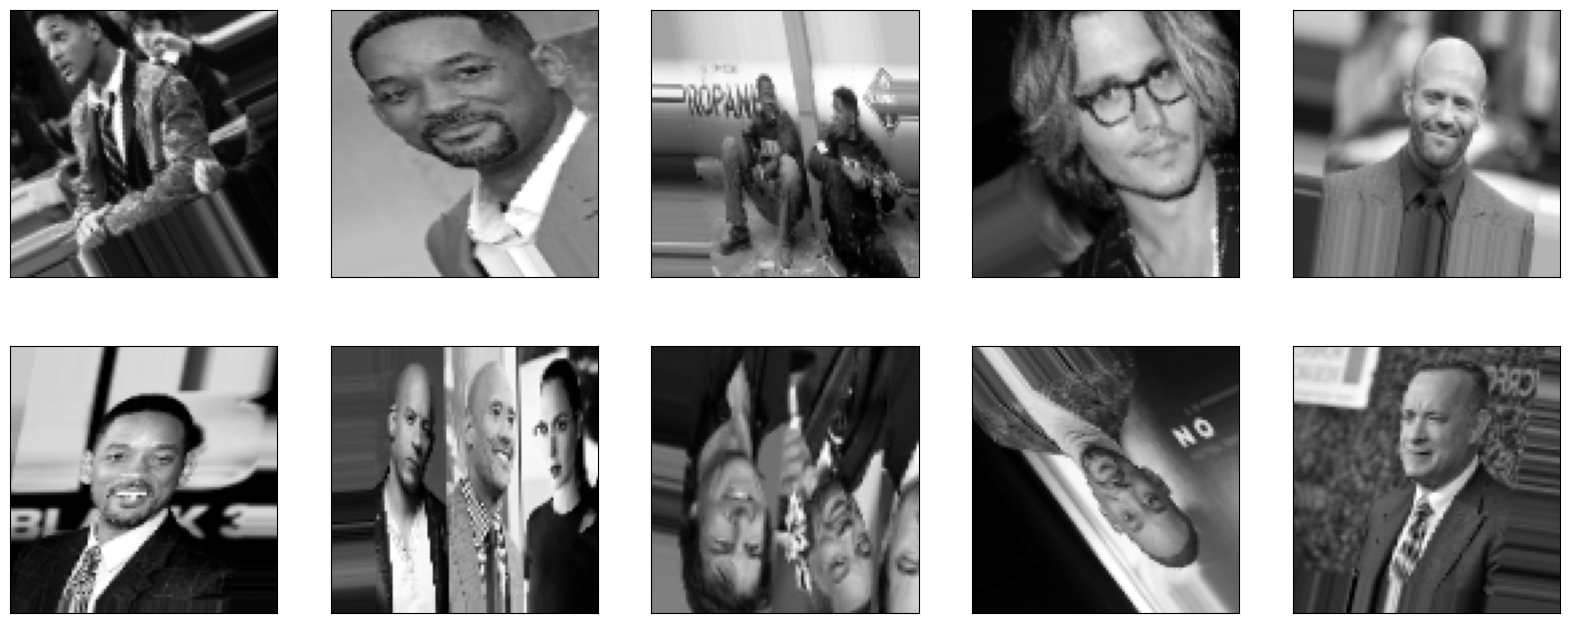

In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de imágenes aumentadas
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajustamos el generador al conjunto de imágenes original
datagen.fit(images)

plt.figure(figsize=(20,8))

# Obtenemos un lote de imágenes aumentadas
for image, label in datagen.flow(images, labels, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    break  # Rompemos el bucle después de mostrar un lote

Generamos más imágenes, para mejorar los resultados:

In [4]:
import numpy as np

# Separa las imágenes en dos grupos
images_will_smith = images[labels == 1]
labels_will_smith = labels[labels == 1]

images_others = images[labels == 0]
labels_others = labels[labels == 0]

# Imágenes que se van a generar para cada grupo
num_required = 750

# Función para aumentar un conjunto de imágenes y etiquetas
def augment_images(images, labels, num_required, datagen):
    num_transformations_per_image = np.ceil((num_required - len(images)) / len(images)).astype(int)
    augmented_images = []
    augmented_labels = []
    for x, y in zip(images, labels):
        for _ in range(num_transformations_per_image):
            for image_batch, label_batch in datagen.flow(x[None], y[None], batch_size=1):
                augmented_images.append(image_batch[0])
                augmented_labels.append(label_batch[0])
                break
        if len(augmented_images) + len(images) >= num_required:
            break
    return np.array(augmented_images), np.array(augmented_labels)

# Aplica el aumento a cada grupo
augmented_images_will, augmented_labels_will = augment_images(images_will_smith, labels_will_smith, num_required, datagen)
augmented_images_others, augmented_labels_others = augment_images(images_others, labels_others, num_required, datagen)

# Combina las imágenes originales y aumentadas para cada grupo
final_images_will = np.concatenate((images_will_smith, augmented_images_will), axis=0)
final_labels_will = np.concatenate((labels_will_smith, augmented_labels_will), axis=0)

final_images_others = np.concatenate((images_others, augmented_images_others), axis=0)
final_labels_others = np.concatenate((labels_others, augmented_labels_others), axis=0)

# Combina los grupos de vuelta en un solo conjunto
final_images = np.concatenate((final_images_will, final_images_others), axis=0)
final_labels = np.concatenate((final_labels_will, final_labels_others), axis=0)

print(len(final_images))

1500


### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

In [5]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.3, random_state=42)

# Creamos el modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuramos el modelo para el entrenamiento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(
    datagen.flow(train_images, train_labels),
    epochs=100, batch_size=32,
    validation_data=(test_images, test_labels),
    steps_per_epoch=int(np.ceil(len(train_images) / float(32))),
    validation_steps=int(np.ceil(len(test_images) / float(32)))
)

Epoch 1/100
33/33 [==============================] - 7s 189ms/step - loss: 0.6917 - accuracy: 0.5400 - val_loss: 0.7001 - val_accuracy: 0.4844
Epoch 2/100
33/33 [==============================] - 6s 187ms/step - loss: 0.6933 - accuracy: 0.5076 - val_loss: 0.6858 - val_accuracy: 0.6400
Epoch 3/100
33/33 [==============================] - 6s 184ms/step - loss: 0.6933 - accuracy: 0.5400 - val_loss: 0.6906 - val_accuracy: 0.4844
Epoch 4/100
33/33 [==============================] - 6s 179ms/step - loss: 0.6916 - accuracy: 0.5352 - val_loss: 0.6813 - val_accuracy: 0.6222
Epoch 5/100
33/33 [==============================] - 6s 180ms/step - loss: 0.6884 - accuracy: 0.5419 - val_loss: 0.6668 - val_accuracy: 0.6311
Epoch 6/100
33/33 [==============================] - 6s 179ms/step - loss: 0.6883 - accuracy: 0.5324 - val_loss: 0.6732 - val_accuracy: 0.6511
Epoch 7/100
33/33 [==============================] - 6s 180ms/step - loss: 0.6732 - accuracy: 0.5771 - val_loss: 0.6374 - val_accuracy: 0.6267

### <span style="color:#77dd77;">Evaluación</span>

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

In [6]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Realizamos las predicciones con los datos de prueba
test_predictions = model.predict(test_images)
test_predictions_rounded = np.round(test_predictions)

# Evaluamos el modelo con diferentes métricas
accuracy = accuracy_score(test_labels, test_predictions_rounded)
f1 = f1_score(test_labels, test_predictions_rounded)
confusion = confusion_matrix(test_labels, test_predictions_rounded)

# Mostramos los resultados
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(confusion)

15/15 [==============================] - 1s 31ms/step
Accuracy: 0.7577777777777778
F1 Score: 0.7447306791569087
[[182  50]
 [ 59 159]]


Extraemos un porcentaje de los fotogramas del tráiler y los almacenamos en un directorio:

In [1]:
import cv2
import os

video_path =  os.getcwd() + '/resources/trailers/BAD_BOYS_RIDE_OR_DIE.mp4'
frames_dir =  os.getcwd() + '/resources/filmFrames/badBoysRideOrDie'
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Cargar el vídeo
vidcap = cv2.VideoCapture(video_path)

# Obtener la tasa de fotogramas (FPS) del vídeo
fps = vidcap.get(cv2.CAP_PROP_FPS)

success, image = vidcap.read()
count = 0
frame_index = 0

skip_frames = int(fps / 2) if fps > 2 else 1

while success:
    # Guardar el fotograma actual en el directorio frames_dir
    if count % skip_frames == 0:
        cv2.imwrite(os.path.join(frames_dir, f"frame{count:04d}.jpg"), image)
        print(f'Procesado fotograma: {count}')
        frame_index += 1
        
    success, image = vidcap.read()
    count += 1

print(f'Fotogramas extraídos: {frame_index}')

Procesado fotograma: 0
Procesado fotograma: 11
Procesado fotograma: 22
Procesado fotograma: 33
Procesado fotograma: 44
Procesado fotograma: 55
Procesado fotograma: 66
Procesado fotograma: 77
Procesado fotograma: 88
Procesado fotograma: 99
Procesado fotograma: 110
Procesado fotograma: 121
Procesado fotograma: 132
Procesado fotograma: 143
Procesado fotograma: 154
Procesado fotograma: 165
Procesado fotograma: 176
Procesado fotograma: 187
Procesado fotograma: 198
Procesado fotograma: 209
Procesado fotograma: 220
Procesado fotograma: 231
Procesado fotograma: 242
Procesado fotograma: 253
Procesado fotograma: 264
Procesado fotograma: 275
Procesado fotograma: 286
Procesado fotograma: 297
Procesado fotograma: 308
Procesado fotograma: 319
Procesado fotograma: 330
Procesado fotograma: 341
Procesado fotograma: 352
Procesado fotograma: 363
Procesado fotograma: 374
Procesado fotograma: 385
Procesado fotograma: 396
Procesado fotograma: 407
Procesado fotograma: 418
Procesado fotograma: 429
Procesado f

Teniendo en cuenta que Will Smith aparece alrededor de 66 segundos en el tráiler, predecimos en cada frame extraído si aparece o no, determinando el tiempo de aparición que el modelo estima:

In [16]:
frames_dir =  os.getcwd() + '/resources/filmFrames/badBoysRideOrDie'

# Enumerar todos los fotogramas extraídos
frame_files = [f for f in os.listdir(frames_dir) if os.path.isfile(os.path.join(frames_dir, f))]

threshold = 0.8
actor_frame_count = 0

for frame_file in frame_files:
    # Cargar el fotograma
    frame_path = os.path.join(frames_dir, frame_file)
    image = cv2.imread(frame_path)
    
    # Preprocesar el fotograma (redimensionar a 100x100 píxeles y convertir a escala de grises)
    image = cv2.resize(image, (100, 100))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(-1, 100, 100, 1) / 255.0  # Normalizar

    # Hacer la predicción usando el modelo
    prediction = model.predict(image)
    print("Prediction: ", prediction)
    if prediction > threshold:
        actor_frame_count += 1

appearance_time = actor_frame_count / 2
print(f"El actor apareció durante {appearance_time} segundos.")


1/1 [==============================] - 0s 33ms/step
Prediction:  [[0.82573646]]
1/1 [==============================] - 0s 24ms/step
Prediction:  [[0.8362899]]
1/1 [==============================] - 0s 30ms/step
Prediction:  [[0.9196759]]
1/1 [==============================] - 0s 29ms/step
Prediction:  [[0.9481287]]
1/1 [==============================] - 0s 18ms/step
Prediction:  [[0.99882716]]
1/1 [==============================] - 0s 21ms/step
Prediction:  [[0.99344003]]
1/1 [==============================] - 0s 26ms/step
Prediction:  [[0.530641]]
1/1 [==============================] - 0s 26ms/step
Prediction:  [[0.66899717]]
1/1 [==============================] - 0s 29ms/step
Prediction:  [[0.9413364]]
1/1 [==============================] - 0s 22ms/step
Prediction:  [[0.0148771]]
1/1 [==============================] - 0s 24ms/step
Prediction:  [[0.48971733]]
1/1 [==============================] - 0s 20ms/step
Prediction:  [[0.46407536]]
1/1 [==============================] - 0s 21ms/

Repetimos la tarea pero intentando predecir la aparición de Will Smith únicamente en los frames en los que el modelo de detección de humanos determina que hay algún humano:

In [21]:
import joblib

human_threshold = 0.5
will_threshold = 0.8
actor_frame_count = 0

human_model = joblib.load('./resources/models/human_detection.joblib')

for frame_file in frame_files:
    # Cargar el fotograma
    frame_path = os.path.join(frames_dir, frame_file)
    image = cv2.imread(frame_path)
    
    # Preprocesar el fotograma (redimensionar a 100x100 píxeles y convertir a escala de grises)
    image = cv2.resize(image, (100, 100))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(-1, 100, 100, 1) / 255.0  # Normalizar

    # Hacer la predicción usando el modelo
    human_prediction = human_model.predict(image)
    print("Human prediction: ", human_prediction)
    if human_prediction > human_threshold:
        prediction = model.predict(image)
        print("Will prediction: ", prediction)
        if prediction > will_threshold:
            actor_frame_count += 1

appearance_time = actor_frame_count / 2
print(f"El actor apareció durante {appearance_time} segundos.")

1/1 [==============================] - 0s 55ms/step
Human prediction:  [[0.5547349]]
1/1 [==============================] - 0s 13ms/step
Will prediction:  [[0.82573646]]
1/1 [==============================] - 0s 7ms/step
Human prediction:  [[0.58751017]]
1/1 [==============================] - 0s 8ms/step
Will prediction:  [[0.8362899]]
1/1 [==============================] - 0s 17ms/step
Human prediction:  [[0.42260173]]
1/1 [==============================] - 0s 10ms/step
Human prediction:  [[0.37171876]]
1/1 [==============================] - 0s 10ms/step
Human prediction:  [[0.62038714]]
1/1 [==============================] - 0s 15ms/step
Will prediction:  [[0.99882716]]
1/1 [==============================] - 0s 8ms/step
Human prediction:  [[0.6915429]]
1/1 [==============================] - 0s 13ms/step
Will prediction:  [[0.99344003]]
1/1 [==============================] - 0s 16ms/step
Human prediction:  [[0.7484136]]
1/1 [==============================] - 0s 31ms/step
Will predicti